## https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria
Healthy or infected cells

In [1]:
import os, shutil
import numpy as np

In [2]:
path = '../datasets/cell_images/'
inf_init = path + 'Parasitized/'
uninf_init = path + 'Uninfected/'

In [3]:
train_images = path + "/malaria/train/"
val_images = path + "/malaria/val/"
test_images = path + "/malaria/test/"

In [4]:
print(len(os.listdir(inf_init)), len(os.listdir(uninf_init)))

13780 13780


In [5]:
# divide infected images into train, val and test folders for image generator. 10k for train, 3k for val, 780 for test
"""for n, i in enumerate(os.listdir(inf_init)):
    if i.endswith(".png"):
        if n < 10000:
            shutil.copyfile(inf_init + i, train_images + 'inf/' + i)
        elif n >= 10000 and n < 13000:
            shutil.copyfile(inf_init + i, val_images + 'inf/' + i)
        else:
            shutil.copyfile(inf_init + i, test_images + 'inf/' + i)"""

# same with not infected
"""for n, i in enumerate(os.listdir(uninf_init)):
    if i.endswith(".png"):
        if n < 10000:
            shutil.copyfile(uninf_init + i, train_images + 'uninf/' + i)
        elif n >= 10000 and n < 13000:
            shutil.copyfile(uninf_init + i, val_images + 'uninf/' + i)
        else:
            shutil.copyfile(uninf_init + i, test_images + 'uninf/' + i)"""

'for n, i in enumerate(os.listdir(uninf_init)):\n    if i.endswith(".png"):\n        if n < 10000:\n            shutil.copyfile(uninf_init + i, train_images + \'uninf/\' + i)\n        elif n >= 10000 and n < 13000:\n            shutil.copyfile(uninf_init + i, val_images + \'uninf/\' + i)\n        else:\n            shutil.copyfile(uninf_init + i, test_images + \'uninf/\' + i)'

In [6]:
len(os.listdir("../datasets/cell_images/malaria/test/uninf/"))

780

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

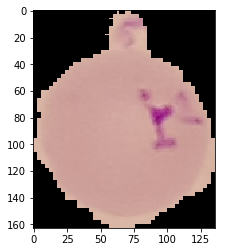

In [9]:
fld = "../datasets/cell_images/malaria/train/inf/"
img = load_img(fld + os.listdir(fld)[200])
img = img_to_array(img)
plt.imshow(img/255.)

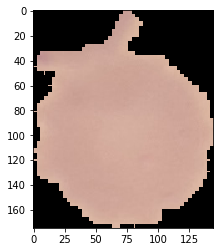

In [10]:
fld = "../datasets/cell_images/malaria/train/uninf/"
img = load_img(fld + os.listdir(fld)[200])
img = img_to_array(img)
plt.imshow(img/255.)

In [11]:
# so, infected ones have the weird dots
image_size = 128

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')

                        
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_images,
        # All images will be resized to 150x150
        target_size=(image_size, image_size),
        batch_size=50,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')#200 steps per epoch

validation_generator = test_datagen.flow_from_directory(
        val_images,
        target_size=(image_size, image_size),
        batch_size=50,
        class_mode='binary')#60 steps per epoch

test_generator = test_datagen.flow_from_directory(
        test_images,
        target_size=(image_size, image_size),
        batch_size=50,
        class_mode='binary')#16 steps per epoch

Found 19998 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.
Found 1560 images belonging to 2 classes.


In [13]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras import callbacks

In [14]:
mobilenet = mobilenet_v2.MobileNetV2(weights = 'imagenet', include_top = False,
                                     input_shape = (image_size, image_size, 3))  # should be fast to train

In [15]:
# mobilenet.trainable = False
trainable = False
first_trainable_layer = 'block_15_expand'
for layer in mobilenet.layers:
    if layer.name == first_trainable_layer:
        trainable = True
        
    layer.trainable = trainable
    
model = models.Sequential()
model.add(mobilenet)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))



model.compile(loss = 'binary_crossentropy', metrics = ['acc'], optimizer='adam')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0         
_________________________________________________________________
dropout (Dropout)            (None, 20480)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2621568   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 4,879,681
Trainable params: 3,827,777
Non-trainable params: 1,051,904
______________________________________

In [17]:
cb = [callbacks.EarlyStopping(monitor='val_loss', patience=5), 
      callbacks.ModelCheckpoint('../saved_models/malaria.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)]

In [18]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=200,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=60, callbacks=cb)

Epoch 1/50
200/200 [==============================] - 37s 186ms/step - loss: 0.3540 - acc: 0.8830 - val_loss: 3.6270 - val_acc: 0.5737
Epoch 2/50
200/200 [==============================] - 30s 149ms/step - loss: 0.2463 - acc: 0.9198 - val_loss: 2.8141 - val_acc: 0.6273
Epoch 3/50
200/200 [==============================] - 29s 146ms/step - loss: 0.2344 - acc: 0.9238 - val_loss: 1.4297 - val_acc: 0.8323
Epoch 4/50
200/200 [==============================] - 29s 147ms/step - loss: 0.2124 - acc: 0.9273 - val_loss: 2.6948 - val_acc: 0.7667
Epoch 5/50
200/200 [==============================] - 30s 148ms/step - loss: 0.2094 - acc: 0.9305 - val_loss: 1.2911 - val_acc: 0.8283
Epoch 6/50
200/200 [==============================] - 30s 148ms/step - loss: 0.1891 - acc: 0.9376 - val_loss: 1.0634 - val_acc: 0.7940
Epoch 7/50
200/200 [==============================] - 29s 147ms/step - loss: 0.1912 - acc: 0.9381 - val_loss: 0.6512 - val_acc: 0.9083
Epoch 8/50
200/200 [==============================] - 3

In [18]:
# not quite the ordinary way of finetuning, but still.
model.load_weights('../saved_models/malaria.hdf5')
model.evaluate_generator(test_generator, steps=16)

[0.22414249717257917, 0.94375]

Custom net

In [19]:
inputShape = (image_size, image_size, 3)

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.BatchNormalization(axis = -1))
model.add(layers.Dropout(0.2))

for flt in [32, 32]:
    model.add(layers.Conv2D(flt, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.BatchNormalization(axis = -1))
    model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization(axis = -1))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', metrics = ['acc'], optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_v2 (Batc (None, 63, 63, 32)        128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 30, 30, 32)       

In [20]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [22]:
cb = [callbacks.EarlyStopping(monitor='val_loss', patience=5), 
      callbacks.ModelCheckpoint('../saved_models/malaria_full.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)]

history = model.fit_generator(
      train_generator,
      steps_per_epoch=200,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=60, callbacks=cb)

Epoch 1/50
200/200 [==============================] - 32s 160ms/step - loss: 0.7570 - acc: 0.6544 - val_loss: 2.9923 - val_acc: 0.5043
Epoch 2/50
200/200 [==============================] - 28s 140ms/step - loss: 0.4201 - acc: 0.8304 - val_loss: 2.6647 - val_acc: 0.5070
Epoch 3/50
200/200 [==============================] - 28s 139ms/step - loss: 0.3509 - acc: 0.8706 - val_loss: 0.7145 - val_acc: 0.7613
Epoch 4/50
200/200 [==============================] - 28s 138ms/step - loss: 0.3270 - acc: 0.8788 - val_loss: 0.3099 - val_acc: 0.8930
Epoch 5/50
200/200 [==============================] - 28s 139ms/step - loss: 0.2986 - acc: 0.8910 - val_loss: 0.2704 - val_acc: 0.9200
Epoch 6/50
200/200 [==============================] - 28s 139ms/step - loss: 0.3010 - acc: 0.8907 - val_loss: 0.2523 - val_acc: 0.9187
Epoch 7/50
200/200 [==============================] - 28s 139ms/step - loss: 0.2849 - acc: 0.8976 - val_loss: 0.2239 - val_acc: 0.9223
Epoch 8/50
200/200 [==============================] - 2

In [21]:
model.load_weights('../saved_models/malaria_full.hdf5')
model.evaluate_generator(test_generator, steps=16)

[0.1290955941658467, 0.95875]

turns out to be a bit better

Label 0.0, prediction 1, 0.5516469478607178


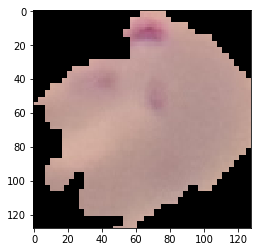

Label 0.0, prediction 1, 0.9824692606925964


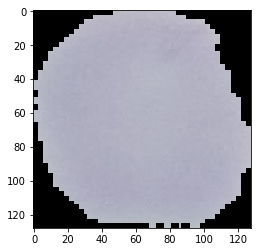

Label 0.0, prediction 1, 0.9563822746276855


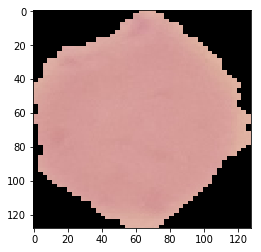

Label 1.0, prediction 0, 0.42083054780960083


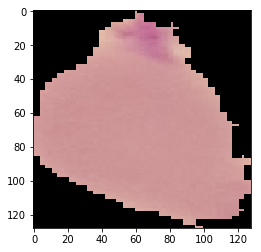

Label 1.0, prediction 0, 0.11555898189544678


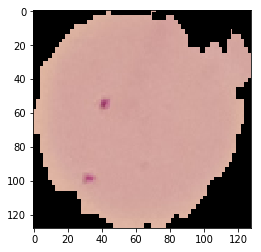

Label 0.0, prediction 1, 0.9497692584991455


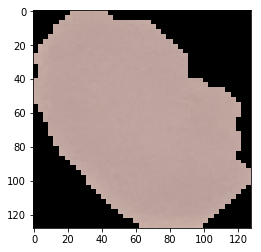

Label 0.0, prediction 1, 0.8788779973983765


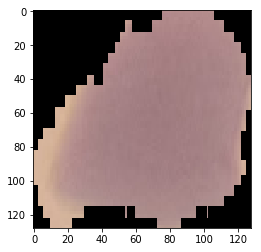

Label 0.0, prediction 1, 0.8826465606689453


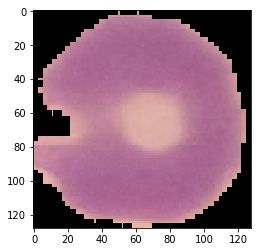

Label 0.0, prediction 1, 0.8529279232025146


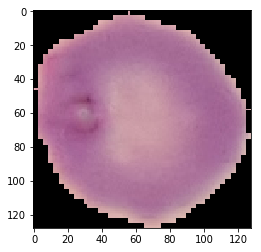

Label 0.0, prediction 1, 0.894505500793457


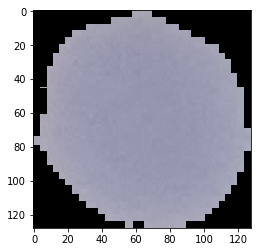

Label 0.0, prediction 1, 0.8103367686271667


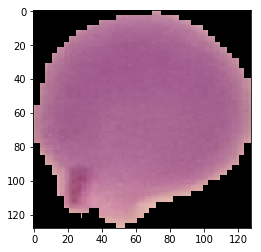

Label 0.0, prediction 1, 0.9145026206970215


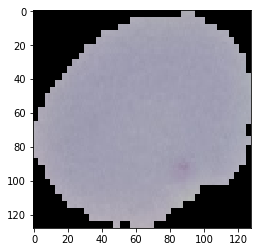

Label 0.0, prediction 1, 0.5140910148620605


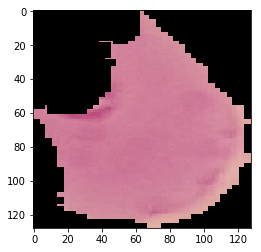

Label 0.0, prediction 1, 0.574617326259613


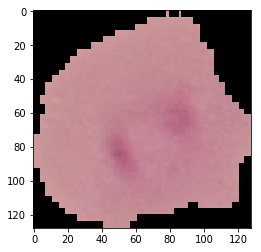

Label 1.0, prediction 0, 0.38373634219169617


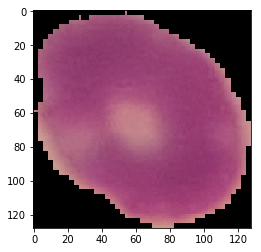

Label 0.0, prediction 1, 0.7619493007659912


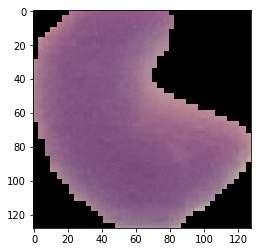

Label 0.0, prediction 1, 0.9050483703613281


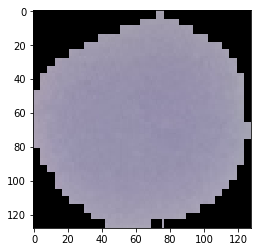

Label 0.0, prediction 1, 0.9715729355812073


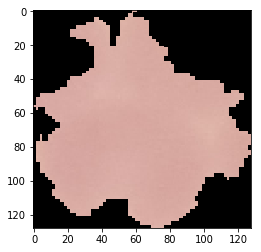

Label 1.0, prediction 0, 0.07613638043403625


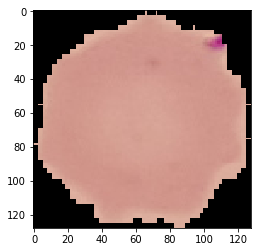

Label 0.0, prediction 1, 0.8897517919540405


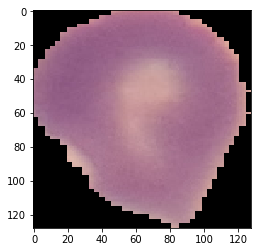

Label 1.0, prediction 0, 0.027623653411865234


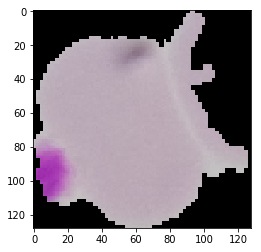

Label 1.0, prediction 0, 0.07444322109222412


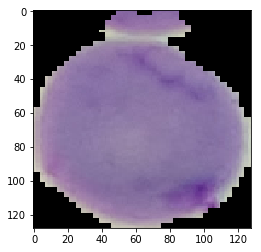

Label 0.0, prediction 1, 0.8924285173416138


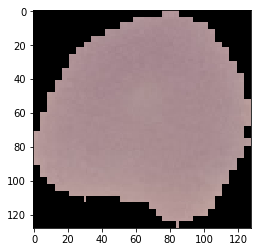

Label 0.0, prediction 1, 0.6693311333656311


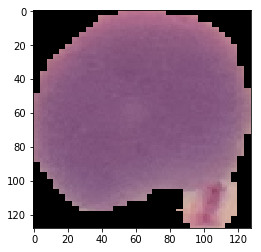

Label 0.0, prediction 1, 0.7152031064033508


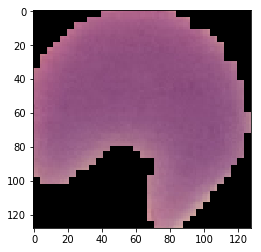

Label 0.0, prediction 1, 0.9110707640647888


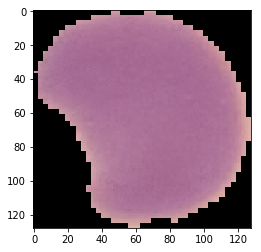

Label 0.0, prediction 1, 0.8693673610687256


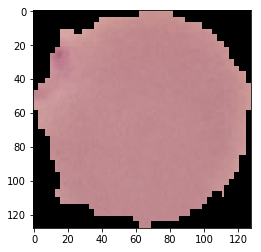

Label 0.0, prediction 1, 0.9518736600875854


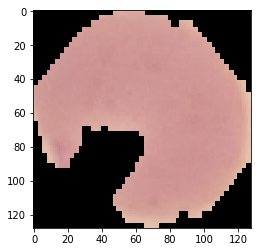

Label 1.0, prediction 0, 0.21364825963974


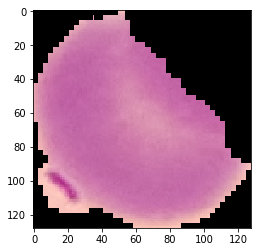

Label 0.0, prediction 1, 0.9698903560638428


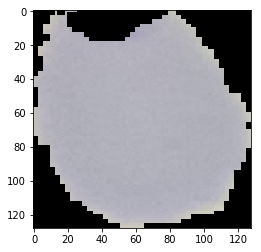

Label 0.0, prediction 1, 0.7103092670440674


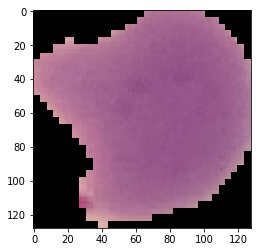

Label 0.0, prediction 1, 0.5161514282226562


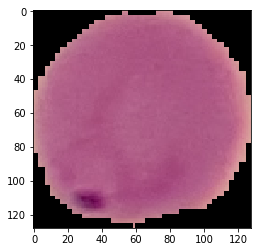

In [37]:
# misclassified
for batch_num in range(16):
    images, labels = test_generator.next()
    predictions = model.predict(images)
    predictions = predictions.reshape((-1, ))
    predictions_round = np.where(predictions > 0.5, 1, 0)
    for i in range(len(predictions_round)):
        if predictions_round[i] != labels[i]:
            print("Label {}, prediction {}, {}".format(labels[i], predictions_round[i], predictions[i]))
            plt.imshow(images[i])
            plt.show()